In [226]:
using Revise; 
includet("TrajModules.jl")
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap
using .IntegrateODE

## Creating the system and light

In [227]:
includet("magneticFields.jl")
using .quadrapole

In [3]:
using BenchmarkTools

In [228]:
BField_Generator = BfieldMag(20.0, 0.0)
Bfield_gen(x,y , z) = Bnorm(BField_Generator, x, y, z)


Bfield_gen (generic function with 1 method)

In [249]:
function rot_mat(pos)
    b_field = B_Field_func(pos...)
 
    beam_dir = Beam.dir
 
    # Compute cross_product and its norm once
    cross_product = cross(b_field, beam_dir)
    cross_product_norm = norm(cross_product)
 
    # If cross_product is almost zero, vectors are parallel or antiparallel
    if cross_product_norm < 1e-6
        dot_product = dot(b_field, beam_dir)
        # If dot_product is negative, vectors are antiparallel
        if dot_product < 0
            # Rotate by 180 degrees about any axis that is not parallel to beam_dir
            axis = if isapprox(abs.(beam_dir), [1, 0, 0], atol=1e-6)
                cross(beam_dir, [0, 1, 0])
            else
                cross(beam_dir, [1, 0, 0])
            end
            return rotation_matrix(axis, π)
        else
            return Matrix(I, 3, 3)
        end
    end
end
rotated_pol(pos) = rot_mat(pos) * Beam.pol
decomposed_pol(pos) = decompose_spherical(rotated_pol(pos))
rot_mat([1e-3, 0, 0])

LoadError: MethodError: no method matching (Matrix)(::Type{Float64}, ::UniformScaling{Bool}, ::Int64, ::Int64)
[0mClosest candidates are:
[0m  (Matrix)([91m::UniformScaling[39m, [91m::Integer[39m, ::Integer) at C:\Users\SimulationComputer\AppData\Local\Programs\Julia-1.8.2\share\julia\stdlib\v1.8\LinearAlgebra\src\uniformscaling.jl:505
[0m  (Matrix)([91m::UndefInitializer[39m, [91m::Integer[39m, ::Integer) at baseext.jl:33

In [ ]:
using Interpolations
function getBFieldInterpolate(Bfield_gen, grid)
    grid = (grid, grid, grid)
    PointGrid = ([i for i in Iterators.product(grid...)])
    B_Field_array_x = [Bfield_gen(PointGrid[i, j, k]...)[1] for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid,3)]
    B_Field_array_y = [Bfield_gen(PointGrid[i, j, k]...)[2] for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid,3)]
    B_Field_array_z = [Bfield_gen(PointGrid[i, j, k]...)[3] for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid,3)]
    B_field_int_x = interpolate(grid, B_Field_array_x, Gridded(Linear()))
    B_field_int_y = interpolate(grid, B_Field_array_y, Gridded(Linear()))
    B_field_int_z = interpolate(grid, B_Field_array_z, Gridded(Linear()))

    B_Field(x, y, z) = [B_field_int_x[x, y, z], B_field_int_y[x, y, z], B_field_int_z[x, y, z]]
    return B_Field
end
gridOI = -5e-3:1.01e-4:5e-3
B_Field_int = getBFieldInterpolate(Bfield_gen, gridOI);


In [241]:
Bfield_gen(1e-3, 0, 0)

3-element Vector{Float64}:
 -0.001198127042551039
  0.0
  0.0

In [239]:
get_scatteringrate(OurSystem.MOTConfig[1], [1e-3, 0, 0])

LoadError: MethodError: no method matching (Matrix)(::Int64, ::Int64, ::Int64)
[0mClosest candidates are:
[0m  (Matrix)([91m::UniformScaling[39m, ::Integer, ::Integer) at C:\Users\SimulationComputer\AppData\Local\Programs\Julia-1.8.2\share\julia\stdlib\v1.8\LinearAlgebra\src\uniformscaling.jl:505
[0m  (Matrix)([91m::UndefInitializer[39m, ::Integer, ::Integer) at baseext.jl:33
[0m  (Matrix)([91m::ArnoldiMethod.Rotation2{Tc, Ts}[39m, ::Int64) where {Tc, Ts} at C:\Users\SimulationComputer\.julia\packages\ArnoldiMethod\JdEiw\src\schurfact.jl:35
[0m  ...

In [247]:
Beam = OurSystem.MOTConfig[1].Beam.beamStruct
B_Field_func = OurSystem.Environment.B_Field
using LinearAlgebra



rotated_pol(pos) = rot_mat(pos) * Beam.pol
decomposed_pol(pos) = decompose_spherical(rotated_pol(pos))


decomposed_pol (generic function with 1 method)

In [206]:
pos = [-1e-3, 0, 0]
println(cross(B_Field_func(pos...), Beam.dir))
println(B_Field_func(pos...), Beam.dir)

[0.0, -0.0, 0.0]
[0.001198127042551039, 0.0, 0.0][-1.0, 0.0, 0.0]


In [230]:
function createSystem(gridOI, B_field)
    atomType = rubidiumAtom
    OurSystem = System(atomType, B_field, gridOI)
    return OurSystem
end
OurSystem = createSystem(gridOI, Bfield_gen);


In [231]:
function createMOT(OurSystem, detuning, I_mot::Vector{T}; updates0 = true) where T
    clear_MOT(OurSystem)
    stateF = (5, 1, 1.5, 3, 3)
    stateI = (5, 0, 0.5, 2, 2)


    println("Setting up MOT")
    LocAll::Vector{Float64} = [0, 0, 0]
    set_MOT(OurSystem, BeamProperties(LocAll, [-1.0, 0.0, 0.0], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot[1], updates0)
    set_MOT(OurSystem, BeamProperties(LocAll, [1.0, 0.0, 0.0], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot[2], updates0)
end
detuning = 3e6
I_mot = [14, 14]#[0.7957747154594766, 0.7957747154594766]
createMOT(OurSystem, detuning, I_mot);

Setting up MOT
Dynamic
Dynamic


In [232]:
clear_beams(OurSystem)
join_beams(OurSystem)
println("Number of Total Beams: ", length(OurSystem.BeamConfig))
println("Number of Tweezers Beams: ", length(OurSystem.TweezerConfig))
println("Number of MOT Beams: ", length(OurSystem.MOTConfig))

Number of Total Beams: 2
Number of Tweezers Beams: 0
Number of MOT Beams: 2


### MOT Field Gradient

In [161]:
using LinearAlgebra
step = 1e-4*10
dbdx = (norm(Bfield_gen(step, 0, 0)) - norm(Bfield_gen(0, 0, 0)))/step*(1e4/100)
dbdy = (norm(Bfield_gen(0, step, 0)) - norm(Bfield_gen(0, 0, 0)))/step*(1e4/100)
dbdz = (norm(Bfield_gen(0, 0, step)) - norm(Bfield_gen(0, 0, 0)))/step*(1e4/100)
println("B_Field Gradient, x = ", dbdx, " G/cm", "; y = ", dbdy, " G/cm; z = ", dbdz, " G/cm")

B_Field Gradient, x = 119.81270425510391 G/cm; y = 119.81270425510391 G/cm; z = 239.64968935656307 G/cm


In [95]:
BField_Generator = BfieldMag(20.0, 0.0)
Bfield_gen(x,y , z) = Bnorm(BField_Generator, x, y, z)

x_i, y_i, z_i = 1e-4, 1e-5, 1e-5
B_Field_int(x_i, y_i, z_i)./Bfield_gen(x_i,y_i , z_i)

3-element Vector{Float64}:
 0.9999999845943043
 5.039605007139476
 0.999999692813863

# Simulation 

In [120]:
OurSystem.Environment.B_Field(0, 0, 0)

0

In [126]:
center = [1e-6, 1e-6, 1e-6]

OurSystem.Environment.B_Field(0, 0, 1e-6)- 
urSystem.Environment.B_Field(0, 0, 0)

3-element Vector{Float64}:
   0.0
 NaN
   2.39635943218895e-6

In [225]:
dt = 2e-9
tspan = (0, 100e-9)
sol = simulate(OurSystem, 1, 1e-3, "Fabs_spont_R", tspan, dt);

-0.000310981164501698660.00031098116450169866


LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching (::Main.CoolTrap.var"#159#169"{Main.CoolTrap.var"#decomposed_pol#163"{Main.CoolTrap.var"#rotated_pol#162"{BeamProperties{Vector{Float64}}, Main.CoolTrap.var"#rot_mat#161"{BeamProperties{Vector{Float64}}, typeof(Bfield_gen)}}}, Int64, Float64, GaussianBeam})(::Vector{Float64})
    Stacktrace:
      [1] [0m[1mget_scatteringrate_abs[22m[0m[1m([22m[90mMBeam[39m::[0mMOT_Beam[90m{Main.CoolTrap.var"#detuning_T#160"{Float64}}[39m, [90mpos[39m::[0mVector[90m{Float64}[39m, [90mvel[39m::[0mVector[90m{Float64}[39m, [90mdetuningOffset[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mMain.CoolTrap[39m [90mc:\Users\SimulationComputer\Documents\JeshurunLuke\TrajSimulation\[39m[90m[4mTrajModules.jl:326[24m[39m
      [2] [0m[1mget_scatteringrate_abs[22m[0m[1m([22m[90mMBeam[39m::[0mMOT_Beam[90m{Main.CoolTrap.var"#detuning_T#160"{Float64}}[39m, [90mpos[39m::[0mVector[90m{Float64}[39m, [90mvel[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mMain.CoolTrap[39m [90mc:\Users\SimulationComputer\Documents\JeshurunLuke\TrajSimulation\[39m[90m[4mTrajModules.jl:355[24m[39m
      [3] [0m[1m(::Main.SystemSetup.var"#27#28"{Vector{Float64}, Vector{Float64}, Float64})[22m[0m[1m([22m[90mbeam[39m::[0mMOT_Beam[90m{Main.CoolTrap.var"#detuning_T#160"{Float64}}[39m[0m[1m)[22m
    [90m    @ [39m[36mMain.SystemSetup[39m [90m.\[39m[90m[4mnone:0[24m[39m
      [4] [0m[1miterate[22m
    [90m    @ [39m[90m.\[39m[90m[4mgenerator.jl:47[24m[39m[90m [inlined][39m
      [5] [0m[1mcollect[22m[0m[1m([22m[90mitr[39m::[0mBase.Generator[90m{Vector{Any}, Main.SystemSetup.var"#27#28"{Vector{Float64}, Vector{Float64}, Float64}}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m.\[39m[90m[4marray.jl:787[24m[39m
      [6] [0m[1mget_Abs[22m[0m[1m([22m[90mSys[39m::[0mSystem, [90mpos[39m::[0mVector[90m{Float64}[39m, [90mvel[39m::[0mVector[90m{Float64}[39m, [90mt[39m::[0mFloat64, [90mAtomInfo[39m::[0mMain.SystemSetup.atomInfo[0m[1m)[22m
    [90m    @ [39m[36mMain.SystemSetup[39m [90mc:\Users\SimulationComputer\Documents\JeshurunLuke\TrajSimulation\[39m[90m[4mTrajModules.jl:841[24m[39m
      [7] [0m[1m(::Main.SystemSetup.var"#RHS#8"{System, Int64, Float64})[22m[0m[1m([22m[90mdy[39m::[0mVector[90m{Float64}[39m, [90my[39m::[0mVector[90m{Float64}[39m, [90mp[39m::[0mTuple[90m{Float64, Int64, Vector{Any}}[39m, [90mt[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[36mMain.SystemSetup[39m [90mc:\Users\SimulationComputer\Documents\JeshurunLuke\TrajSimulation\[39m[90m[4mTrajModules.jl:853[24m[39m
      [8] [0m[1mVoid[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\SciMLBase\kTUaf\src\[39m[90m[4mutils.jl:473[24m[39m[90m [inlined][39m
      [9] [0m[1m(::FunctionWrappers.CallWrapper{Nothing})[22m[0m[1m([22m[90mf[39m::[0mSciMLBase.Void[90m{Main.SystemSetup.var"#RHS#8"{System, Int64, Float64}}[39m, [90marg1[39m::[0mVector[90m{Float64}[39m, [90marg2[39m::[0mVector[90m{Float64}[39m, [90marg3[39m::[0mTuple[90m{Float64, Int64, Vector{Any}}[39m, [90marg4[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[32mFunctionWrappers[39m [90mC:\Users\SimulationComputer\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:65[24m[39m
     [10] [0m[1mmacro expansion[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:137[24m[39m[90m [inlined][39m
     [11] [0m[1mdo_ccall[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:125[24m[39m[90m [inlined][39m
     [12] [0m[1mFunctionWrapper[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:144[24m[39m[90m [inlined][39m
     [13] [0m[1m_call[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\FunctionWrappersWrappers\9XR0m\src\[39m[90m[4mFunctionWrappersWrappers.jl:12[24m[39m[90m [inlined][39m
     [14] [0m[1mFunctionWrappersWrapper[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\FunctionWrappersWrappers\9XR0m\src\[39m[90m[4mFunctionWrappersWrappers.jl:10[24m[39m[90m [inlined][39m
     [15] [0m[1mODEFunction[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\SciMLBase\kTUaf\src\[39m[90m[4mscimlfunctions.jl:2127[24m[39m[90m [inlined][39m
     [16] [0m[1minitialize![22m[0m[1m([22m[90mintegrator[39m::[0mOrdinaryDiffEq.ODEIntegrator[90m{OrdinaryDiffEq.RK4{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, true, Vector{Float64}, Nothing, Float64, Tuple{Float64, Int64, Vector{Any}}, Float64, Float64, Float64, Float64, Vector{Vector{Float64}}, SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{Float64, Int64, Vector{Any}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, OrdinaryDiffEq.RK4{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.RK4Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, DiffEqBase.Stats, Nothing}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.RK4Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, OrdinaryDiffEq.PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(opnorm), Nothing, SciMLBase.CallbackSet{Tuple{}, Tuple{SciMLBase.DiscreteCallback{Main.IntegrateODE.var"#conditionStop#4"{Float64, Float64}, Main.IntegrateODE.var"#affect!#5", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit}[39m, [90mcache[39m::[0mOrdinaryDiffEq.RK4Cache[90m{Vector{Float64}, Vector{Float64}, Vector{Float64}, typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}[39m[0m[1m)[22m
    [90m    @ [39m[33mOrdinaryDiffEq[39m [90mC:\Users\SimulationComputer\.julia\packages\OrdinaryDiffEq\xaB2l\src\perform_step\[39m[90m[4mfixed_timestep_perform_step.jl:328[24m[39m
     [17] [0m[1m__init[22m[0m[1m([22m[90mprob[39m::[0mSciMLBase.ODEProblem[90m{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{Float64, Int64, Vector{Any}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{Float64, Int64, Vector{Any}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, [90malg[39m::[0mOrdinaryDiffEq.RK4[90m{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}[39m, [90mtimeseries_init[39m::[0mTuple[90m{}[39m, [90mts_init[39m::[0mTuple[90m{}[39m, [90mks_init[39m::[0mTuple[90m{}[39m, [90mrecompile[39m::[0mType[90m{Val{true}}[39m; [90msaveat[39m::[0mTuple[90m{}[39m, [90mtstops[39m::[0mTuple[90m{}[39m, [90md_discontinuities[39m::[0mTuple[90m{}[39m, [90msave_idxs[39m::[0mNothing, [90msave_everystep[39m::[0mBool, [90msave_on[39m::[0mBool, [90msave_start[39m::[0mBool, [90msave_end[39m::[0mNothing, [90mcallback[39m::[0mSciMLBase.DiscreteCallback[90m{Main.IntegrateODE.var"#conditionStop#4"{Float64, Float64}, Main.IntegrateODE.var"#affect!#5", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}[39m, [90mdense[39m::[0mBool, [90mcalck[39m::[0mBool, [90mdt[39m::[0mFloat64, [90mdtmin[39m::[0mNothing, [90mdtmax[39m::[0mFloat64, [90mforce_dtmin[39m::[0mBool, [90madaptive[39m::[0mBool, [90mgamma[39m::[0mRational[90m{Int64}[39m, [90mabstol[39m::[0mNothing, [90mreltol[39m::[0mNothing, [90mqmin[39m::[0mRational[90m{Int64}[39m, [90mqmax[39m::[0mInt64, [90mqsteady_min[39m::[0mInt64, [90mqsteady_max[39m::[0mInt64, [90mbeta1[39m::[0mNothing, [90mbeta2[39m::[0mNothing, [90mqoldinit[39m::[0mRational[90m{Int64}[39m, [90mcontroller[39m::[0mNothing, [90mfullnormalize[39m::[0mBool, [90mfailfactor[39m::[0mInt64, [90mmaxiters[39m::[0mInt64, [90minternalnorm[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_NORM), [90minternalopnorm[39m::[0mtypeof(opnorm), [90misoutofdomain[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), [90munstable_check[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), [90mverbose[39m::[0mBool, [90mtimeseries_errors[39m::[0mBool, [90mdense_errors[39m::[0mBool, [90madvance_to_tstop[39m::[0mBool, [90mstop_at_next_tstop[39m::[0mBool, [90minitialize_save[39m::[0mBool, [90mprogress[39m::[0mBool, [90mprogress_steps[39m::[0mInt64, [90mprogress_name[39m::[0mString, [90mprogress_message[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), [90muserdata[39m::[0mNothing, [90mallow_extrapolation[39m::[0mBool, [90minitialize_integrator[39m::[0mBool, [90malias_u0[39m::[0mBool, [90malias_du0[39m::[0mBool, [90minitializealg[39m::[0mOrdinaryDiffEq.DefaultInit, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
    [90m    @ [39m[33mOrdinaryDiffEq[39m [90mC:\Users\SimulationComputer\.julia\packages\OrdinaryDiffEq\xaB2l\src\[39m[90m[4msolve.jl:499[24m[39m
     [18] [0m[1m#__solve#648[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\OrdinaryDiffEq\xaB2l\src\[39m[90m[4msolve.jl:5[24m[39m[90m [inlined][39m
     [19] [0m[1m#solve_call#22[22m
    [90m    @ [39m[90mC:\Users\SimulationComputer\.julia\packages\DiffEqBase\9rTlH\src\[39m[90m[4msolve.jl:511[24m[39m[90m [inlined][39m
     [20] [0m[1msolve_up[22m[0m[1m([22m[90mprob[39m::[0mSciMLBase.ODEProblem[90m{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{Float64, Int64, Vector{Any}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, Main.SystemSetup.var"#RHS#8"{System, Int64, Float64}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, [90msensealg[39m::[0mNothing, [90mu0[39m::[0mVector[90m{Float64}[39m, [90mp[39m::[0mTuple[90m{Float64, Int64, Vector{Any}}[39m, [90margs[39m::[0mOrdinaryDiffEq.RK4[90m{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:dt, :adaptive, :callback), Tuple{Float64, Bool, SciMLBase.DiscreteCallback{Main.IntegrateODE.var"#conditionStop#4"{Float64, Float64}, Main.IntegrateODE.var"#affect!#5", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}}[39m[0m[1m)[22m
    [90m    @ [39m[35mDiffEqBase[39m [90mC:\Users\SimulationComputer\.julia\packages\DiffEqBase\9rTlH\src\[39m[90m[4msolve.jl:972[24m[39m
     [21] [0m[1msolve[22m[0m[1m([22m[90mprob[39m::[0mSciMLBase.ODEProblem[90m{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{Float64, Int64, Vector{Any}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, Main.SystemSetup.var"#RHS#8"{System, Int64, Float64}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, [90margs[39m::[0mOrdinaryDiffEq.RK4[90m{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}[39m; [90msensealg[39m::[0mNothing, [90mu0[39m::[0mNothing, [90mp[39m::[0mNothing, [90mwrap[39m::[0mVal[90m{true}[39m, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:dt, :adaptive, :callback), Tuple{Float64, Bool, SciMLBase.DiscreteCallback{Main.IntegrateODE.var"#conditionStop#4"{Float64, Float64}, Main.IntegrateODE.var"#affect!#5", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}}[39m[0m[1m)[22m
    [90m    @ [39m[35mDiffEqBase[39m [90mC:\Users\SimulationComputer\.julia\packages\DiffEqBase\9rTlH\src\[39m[90m[4msolve.jl:882[24m[39m
     [22] [0m[1mintegrate[22m[0m[1m([22m[90mSys[39m::[0mSystem, [90mu0[39m::[0mVector[90m{Float64}[39m, [90mparam[39m::[0mTuple[90m{Float64, Int64, Vector{Any}}[39m, [90mRHS[39m::[0mFunction, [90mtspan[39m::[0mTuple[90m{Int64, Float64}[39m, [90mdt[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[36mMain.IntegrateODE[39m [90mc:\Users\SimulationComputer\Documents\JeshurunLuke\TrajSimulation\[39m[90m[4mTrajModules.jl:946[24m[39m
     [23] [0m[1mmacro expansion[22m
    [90m    @ [39m[90mc:\Users\SimulationComputer\Documents\JeshurunLuke\TrajSimulation\[39m[90m[4mTrajModules.jl:895[24m[39m[90m [inlined][39m
     [24] [0m[1m(::Main.IntegrateODE.var"#71#threadsfor_fun#2"{Main.IntegrateODE.var"#71#threadsfor_fun#1#3"{System, Float64, String, Tuple{Int64, Float64}, Float64, Vector{Any}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[36mMain.IntegrateODE[39m [90m.\[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [25] [0m[1m#71#threadsfor_fun[22m
    [90m    @ [39m[90m.\[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [26] [0m[1m(::Base.Threads.var"#1#2"{Main.IntegrateODE.var"#71#threadsfor_fun#2"{Main.IntegrateODE.var"#71#threadsfor_fun#1#3"{System, Float64, String, Tuple{Int64, Float64}, Float64, Vector{Any}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[90mBase.Threads[39m [90m.\[39m[90m[4mthreadingconstructs.jl:30[24m[39m

In [185]:
timeEval, x, y, z, vx, vy, vz, photons = processData(sol)

([0.0, 2.0e-9, 4.0e-9, 6.000000000000001e-9, 8.0e-9, 1.0e-8, 1.2e-8, 1.4e-8, 1.6e-8, 1.8000000000000002e-8  …  8.200000000000003e-8, 8.400000000000004e-8, 8.600000000000004e-8, 8.800000000000005e-8, 9.000000000000005e-8, 9.200000000000006e-8, 9.400000000000006e-8, 9.600000000000007e-8, 9.800000000000007e-8, 1.0e-7], Any[[-0.00037609204811273224, -0.0003760924476825628, -0.00037609284725239337, -0.00037609324682222393, -0.0003760936463920545, -0.00037609404596188506, -0.00037609444553171563, -0.0003760948451015462, -0.00037609524467137676, -0.0003760956442412073  …  -0.00037610858033906326, -0.00037610898194453756, -0.00037610938355001186, -0.00037610978515548616, -0.00037611018676096046, -0.00037611058836643476, -0.00037611098997190906, -0.00037611139157738336, -0.00037611180299015336, -0.0003761122163643825]], Any[[-0.000374197689691594, -0.0003741981973829145, -0.000374198705074235, -0.0003741992127655555, -0.00037419972045687604, -0.00037420022814819656, -0.0003742007358395171, -0.0

In [165]:
using PyPlot

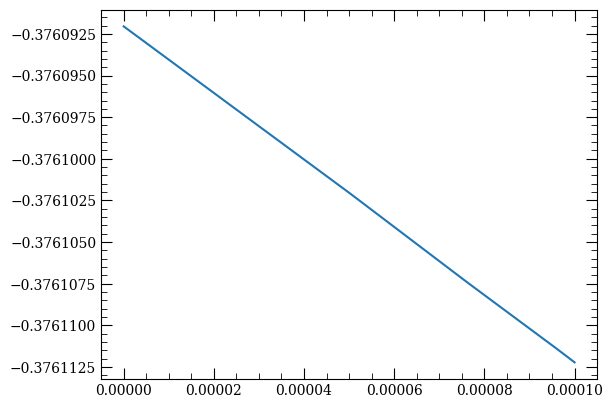

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000001561FF108>

In [186]:

plot(timeEval*1e3, x[1]*1e3)
